<a href="https://colab.research.google.com/github/virgiawan/yog2a-melanoma/blob/master/Melanoma_(Wildan).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Title
---

## Explore the Example Data

Sebelum mengimport data dari Kaggle, kita perlu mendownload API token terlebih dahulu. API token ini bisa kita download dengan cara: **Login di Kaggle > My Account > Home > Create New API Token**. API token ini akan terdownload dalam bentuk file kaggle.json dan harus kita upload ke google colab

In [1]:
from google.colab import files
files.upload() # upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abuwildanm","key":"cf45bfabf4aeb5a95547f59e04a023be"}'}

Supaya dapat mengimport dataset dari Kaggle, jalankan perintah berikut

In [2]:
# Install kaggle library 
!pip install -q kaggle
# Make ".kaggle" directory in root directory
!mkdir -p ~/.kaggle
# Copy the API token to the kaggle directory
!cp kaggle.json ~/.kaggle/
# Check the directory
!ls ~/.kaggle
# Adjust access permissions
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


Setelah itu kita dapat mendownload dataset dari Kaggle dengan perintah berikut

In [3]:
# Download the data
!kaggle datasets download -d drscarlat/melanoma
!unzip -q melanoma.zip -d .
!ls

100% 5.26G/5.26G [01:59<00:00, 56.7MB/s]
100% 5.26G/5.26G [01:59<00:00, 47.4MB/s]
dermmel  DermMel  kaggle.json  melanoma.zip  sample_data


Dataset tersebut berisi beberapa direktori yang menyimpan data untuk training, validation, dan testing. Oleh karena itu, untuk setiap direktori yang ada, kita perlu menyimpan path-nya.

Dataset tersebut juga berisi 2 subdirektori yang mendefinisikan label yaitu `Melanoma` dan `NotMelanoma`. Training set kita gunakan untuk melatih neural network mana gambar yang memiliki penyakit pneumonia atau tidak. Validation set adalah dataset yang belum terlihat sebelumnya oleh neural network sehingga kita bisa menguji performa neural network. Test set adalah dataset yang digunakan untuk menguji kemampuan neural network setelah dilakukan training dan validation.

In [0]:
import os

base_dir = '/content/DermMel'

train_dir = os.path.join(base_dir, 'train_sep')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# Label
melanoma = 'Melanoma'
not_melanoma = 'NotMelanoma'

# Train dataset directory
train_melanoma_dir = os.path.join(train_dir, melanoma)
train_not_melanoma_dir = os.path.join(train_dir, not_melanoma)

# Validation dataset directory
validation_melanoma_dir = os.path.join(validation_dir, melanoma)
validation_not_melanoma_dir = os.path.join(validation_dir, not_melanoma)

# Test dataset directory
test_melanoma_dir = os.path.join(test_dir, melanoma)
test_not_melanoma_dir = os.path.join(test_dir, not_melanoma)

In [5]:
train_melanoma_fnames = os.listdir(train_melanoma_dir)
train_not_melanoma_fnames = os.listdir(train_not_melanoma_dir)

print(train_melanoma_fnames[:10])
print(train_not_melanoma_fnames[:10])

['AUGmented_0_7421.jpeg', 'AUG_0_1445.jpeg', 'AUG_0_6521.jpeg', 'AUG_0_1541.jpeg', 'AUG_0_9750.jpeg', 'AUG_0_1360.jpeg', 'AUGmented_0_2984.jpeg', 'AUG_0_5365.jpeg', 'AUGmented_0_5608.jpeg', 'AUG_0_1379.jpeg']
['ISIC_0031018.jpg', 'ISIC_0026581.jpg', 'ISIC_0031155.jpg', 'ISIC_0031947.jpg', 'ISIC_0031548.jpg', 'ISIC_0027495.jpg', 'ISIC_0027576.jpg', 'ISIC_0026180.jpg', 'ISIC_0028260.jpg', 'ISIC_0024635.jpg']


In [6]:
total_train = len(os.listdir(train_melanoma_dir)) + len(os.listdir(train_not_melanoma_dir))
total_validation = len(os.listdir(validation_melanoma_dir)) + len(os.listdir(validation_not_melanoma_dir))
total_test = len(os.listdir(test_melanoma_dir)) + len(os.listdir(test_not_melanoma_dir))

print('Total training melanoma images:', len(os.listdir(train_melanoma_dir)))
print('Total training not melanoma images:', len(os.listdir(train_not_melanoma_dir)))
print('Total training images:', total_train)
print()
print('Total validation melanoma images:', len(os.listdir(validation_melanoma_dir)))
print('Total validation not melanoma images:', len(os.listdir(validation_not_melanoma_dir)))
print('Total validation images:', total_validation)
print()
print('Total testing melanoma images:', len(os.listdir(test_melanoma_dir)))
print('Total testing not melanoma images:', len(os.listdir(test_not_melanoma_dir)))
print('Total testing images:', total_test)

Total training melanoma images: 5341
Total training not melanoma images: 5341
Total training images: 10682

Total validation melanoma images: 1781
Total validation not melanoma images: 1781
Total validation images: 3562

Total testing melanoma images: 1781
Total testing not melanoma images: 1780
Total testing images: 3561


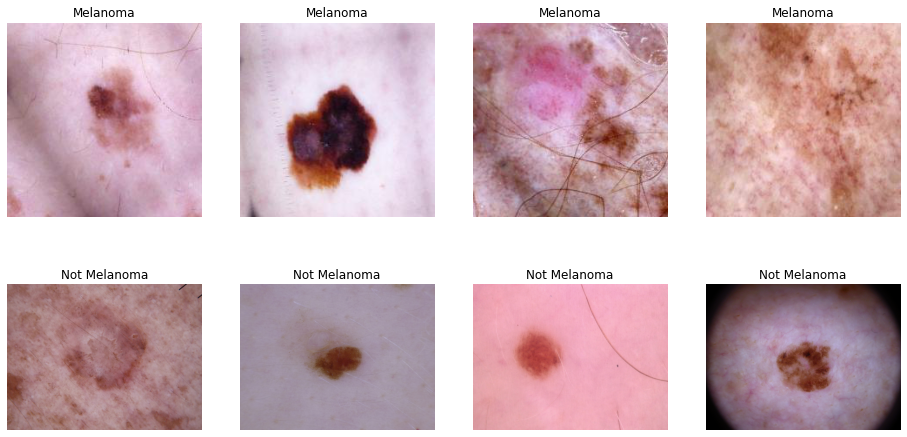

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf

nrows = 2
ncols = 4
img_index = int(nrows*ncols / 2)

# Set up matplotlib fig, and size it to fit 2x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

# Pick random image from train melanoma
melanoma_fnames = (tf.random.shuffle(train_melanoma_fnames)[:img_index]).numpy()
melanoma_fnames = [tf.compat.as_str(fname) for fname in melanoma_fnames]
melanoma_images = [os.path.join(train_melanoma_dir, fname) 
                for fname in melanoma_fnames]

# Pick random image from train not melanoma
not_melanoma_fnames = (tf.random.shuffle(train_not_melanoma_fnames)[:img_index]).numpy()
not_melanoma_fnames = [tf.compat.as_str(fname) for fname in not_melanoma_fnames]
not_melanoma_images = [os.path.join(train_not_melanoma_dir, fname) 
                for fname in not_melanoma_fnames]

for i, img_path in enumerate(melanoma_images + not_melanoma_images):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('Off') # Don't show axes (or gridlines)

    if i < len(melanoma_images):
        plt.title('Melanoma')
    else:
        plt.title('Not Melanoma')

    img = plt.imread(img_path)
    plt.imshow(img)

plt.show()

In [8]:
img = plt.imread(not_melanoma_images[0])
img.shape

(450, 600, 3)

## Building Baseline Model

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop, SGD

model = Sequential([
    # Note the input shape is the desired size of the image 224x224 with 3 bytes color
    Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2), 
    Conv2D(64, (3,3), activation='relu'), 
    MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    Flatten(), 
    # 512 neuron hidden layer
    Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('melanoma') and 1 for the other ('not melanoma')
    Dense(1, activation='sigmoid')  
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 20
target_size = (224, 224)

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')
# train_datagen = ImageDataGenerator(rescale = 1.0/255)
validation_datagen = ImageDataGenerator(rescale = 1.0/255)
test_datagen  = ImageDataGenerator(rescale = 1.0/255)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    target_size=target_size)     
# --------------------
# Flow validation images in batches of 20 using validation_datagen generator
# --------------------
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              batch_size=batch_size,
                                                              class_mode='binary',
                                                              target_size=target_size)
# --------------------
# Flow testing images in batches of 20 using test_datagen generator
# --------------------
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=batch_size,
                                                  class_mode='binary',
                                                  target_size=target_size)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


In [12]:
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'Melanoma': 0, 'NotMelanoma': 1}
{'Melanoma': 0, 'NotMelanoma': 1}
{'Melanoma': 0, 'NotMelanoma': 1}


In [13]:
from tensorflow.keras.callbacks import Callback, EarlyStopping

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

# callbacks = myCallback()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=100,
                    epochs=100,
                    validation_steps=50,
                    callbacks=[early_stopping],
                    verbose=2)

Epoch 1/100
100/100 - 51s - loss: 0.7617 - accuracy: 0.6005 - val_loss: 0.5937 - val_accuracy: 0.6670
Epoch 2/100
100/100 - 49s - loss: 0.5736 - accuracy: 0.6730 - val_loss: 0.6220 - val_accuracy: 0.6480
Epoch 3/100
100/100 - 46s - loss: 0.5856 - accuracy: 0.6590 - val_loss: 0.5311 - val_accuracy: 0.7380
Epoch 4/100
100/100 - 45s - loss: 0.5690 - accuracy: 0.6815 - val_loss: 0.5157 - val_accuracy: 0.7210
Epoch 5/100
100/100 - 44s - loss: 0.5447 - accuracy: 0.7050 - val_loss: 0.5461 - val_accuracy: 0.6820
Epoch 6/100
100/100 - 43s - loss: 0.5482 - accuracy: 0.6995 - val_loss: 0.5057 - val_accuracy: 0.7400
Epoch 7/100
100/100 - 43s - loss: 0.5274 - accuracy: 0.7235 - val_loss: 0.5527 - val_accuracy: 0.6990
Epoch 8/100
100/100 - 42s - loss: 0.5253 - accuracy: 0.7295 - val_loss: 0.5080 - val_accuracy: 0.7890
Epoch 9/100
100/100 - 43s - loss: 0.5009 - accuracy: 0.7470 - val_loss: 0.5101 - val_accuracy: 0.7330


In [14]:
model.evaluate(test_generator)

179/179 [==============================] - 31s 176ms/step - loss: 0.5451 - accuracy: 0.7270


[0.5451194047927856, 0.7270429730415344]

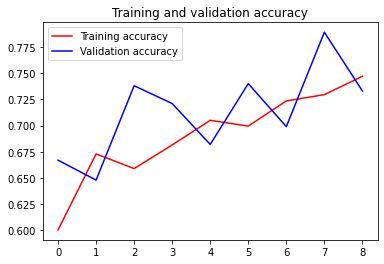

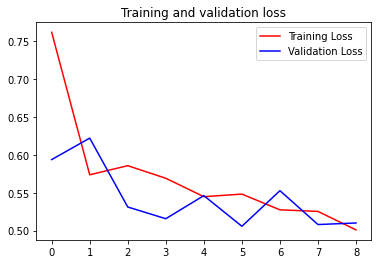

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Building Improvement Model

### Scratch

In [0]:
model = Sequential([
    # Note the input shape is the desired size of the image 224x224 with 3 bytes color
    Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    # BatchNormalization(),
    MaxPooling2D(2,2), 
    Conv2D(64, (3,3), activation='relu'),
    # BatchNormalization(), 
    MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    Flatten(),
    Dropout(0.2), 
    # 512 neuron hidden layer
    Dense(512, activation='relu'),
    Dropout(0.2), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('melanoma') and 1 for the other ('not melanoma')
    Dense(1, activation='sigmoid')  
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 43264)            

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=100,
                    epochs=100,
                    validation_steps=50,
                    callbacks=[early_stopping],
                    verbose=2)

Epoch 1/100
100/100 - 17s - loss: 0.8241 - accuracy: 0.6175 - val_loss: 0.5974 - val_accuracy: 0.6610
Epoch 2/100
100/100 - 17s - loss: 0.5977 - accuracy: 0.6640 - val_loss: 0.5218 - val_accuracy: 0.7110
Epoch 3/100
100/100 - 17s - loss: 0.5434 - accuracy: 0.6960 - val_loss: 0.6493 - val_accuracy: 0.6510
Epoch 4/100
100/100 - 18s - loss: 0.5412 - accuracy: 0.6910 - val_loss: 0.5138 - val_accuracy: 0.7210
Epoch 5/100
100/100 - 17s - loss: 0.5390 - accuracy: 0.7180 - val_loss: 0.5675 - val_accuracy: 0.6590
Epoch 6/100
100/100 - 18s - loss: 0.5396 - accuracy: 0.7301 - val_loss: 0.5291 - val_accuracy: 0.7100
Epoch 7/100
100/100 - 17s - loss: 0.5180 - accuracy: 0.7240 - val_loss: 0.5032 - val_accuracy: 0.7280
Epoch 8/100
100/100 - 18s - loss: 0.5198 - accuracy: 0.7190 - val_loss: 0.4831 - val_accuracy: 0.7680
Epoch 9/100
100/100 - 17s - loss: 0.4678 - accuracy: 0.7755 - val_loss: 0.4538 - val_accuracy: 0.7910
Epoch 10/100
100/100 - 18s - loss: 0.4905 - accuracy: 0.7495 - val_loss: 0.4355 - 

In [0]:
model.evaluate(test_generator)

179/179 [==============================] - 20s 112ms/step - loss: 0.5144 - accuracy: 0.7459


[0.5143885016441345, 0.7458578944206238]

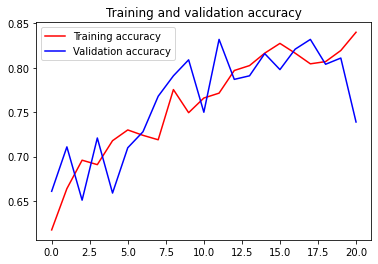

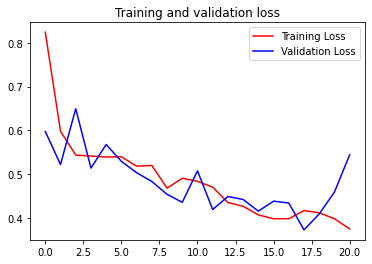

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Pre-trained

In [16]:
from tensorflow.keras.applications import MobileNetV2, InceptionV3, Xception, DenseNet121

pretrained_model = InceptionV3(input_shape=(224,224,3), include_top=False)
pretrained_model.trainable = False

print(pretrained_model.summary())

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________

In [17]:
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, ReLU, Add, DepthwiseConv2D

# Baseline
# model = Sequential()
# model.add(pretrained_model)
# model.add(Flatten())
# # model.add(Dropout(0.2))
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))

# Improvement InceptionV3
last_layer = pretrained_model.get_layer('mixed9')
x = Flatten()(last_layer.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(pretrained_model.input, x)

# Improvement 1
# model = Sequential()
# model.add(pretrained_model)
# # model.add(Conv2D(2560, (1,1), name='Conv_2'))
# # model.add(BatchNormalization(name='Conv_2_bn'))
# # model.add(ReLU(name='out_relu_2'))
# # model.add(Conv2D(5120, (1,1), name='Conv_3'))
# # model.add(BatchNormalization(name='Conv_3_bn'))
# # model.add(ReLU(name='out_relu_3'))
# model.add(GlobalAveragePooling2D())
# model.add(Dropout(0.2))
# model.add(Dense(1280, activation='relu'))
# model.add(Dropout(0.2))
# # model.add(Dense(1280, activation='relu'))
# # model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))

# Improvement 2
# last_layer = pretrained_model.get_layer('block_16_depthwise_relu')
# project_out = Conv2D(160, (1,1), padding='same', name='block_16_project')(last_layer.output)
# project_bn_out = BatchNormalization(momentum=0.999, name='block_16_project_BN')(project_out)
# x = Add(name='block_16_add')([project_out, project_bn_out])
# x = Conv2D(960, (1,1), padding='same', name='block_17_expand')(x)
# x = BatchNormalization(momentum=0.999, name='block_17_expand_BN')(x)
# x = ReLU(max_value=6, name='block_17_expand_relu')(x)
# x = DepthwiseConv2D((3,3), padding='same', name='block_17_depthwise')(x)
# x = BatchNormalization(momentum=0.999, name='block_17_depthwise_BN')(x)
# x = ReLU(max_value=6, name='block_17_depthwise_relu')(x)
# x = Conv2D(320, (1,1), padding='same', name='block_17_project')(x)
# x = BatchNormalization(momentum=0.999, name='block_17_project_BN')(x)
# x = Conv2D(1280, (1,1), padding='valid', name='Conv_1')(x)
# x = BatchNormalization(momentum=0.999, name='Conv_1_bn')(x)
# x = ReLU(max_value=6, name='out_relu')(x)
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.2)(x)
# x = Dense(1280, activation='relu')(x)
# x = Dropout(0.2)(x)
# x = Dense(1, activation='sigmoid')(x)
# model = Model(pretrained_model.input, x)

# Improvement 3
# last_layer = pretrained_model.get_layer('block_15_project_BN')
# project_out = Conv2D(160, (1,1), padding='same', name='block_16_project')(last_layer.output)
# project_bn_out = BatchNormalization(momentum=0.999, name='block_16_project_BN')(project_out)
# x = Add(name='block_16_add')([project_out, project_bn_out])
# x = Conv2D(960, (1,1), padding='same', name='block_17_expand')(x)
# x = BatchNormalization(momentum=0.999, name='block_17_expand_BN')(x)
# x = ReLU(max_value=6, name='block_17_expand_relu')(x)
# x = DepthwiseConv2D((3,3), padding='same', name='block_17_depthwise')(x)
# x = BatchNormalization(momentum=0.999, name='block_17_depthwise_BN')(x)
# x = ReLU(max_value=6, name='block_17_depthwise_relu')(x)
# x = Conv2D(320, (1,1), padding='same', name='block_17_project')(x)
# x = BatchNormalization(momentum=0.999, name='block_17_project_BN')(x)
# x = Conv2D(1280, (1,1), padding='valid', name='Conv_1')(x)
# x = BatchNormalization(momentum=0.999, name='Conv_1_bn')(x)
# x = ReLU(max_value=6, name='out_relu')(x)
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.2)(x)
# x = Dense(1280, activation='relu')(x)
# x = Dropout(0.2)(x)
# x = Dense(1, activation='sigmoid')(x)
# model = Model(pretrained_model.input, x)

model.compile(optimizer=Adam(learning_rate=1e-03), loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-04)

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=total_train // batch_size,
                    epochs=50,
                    validation_steps=total_validation // batch_size,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=2)

Epoch 1/50
534/534 - 233s - loss: 0.3310 - accuracy: 0.8867 - val_loss: 0.1839 - val_accuracy: 0.9270 - lr: 0.0010
Epoch 2/50
534/534 - 228s - loss: 0.2237 - accuracy: 0.9106 - val_loss: 0.1853 - val_accuracy: 0.9315 - lr: 0.0010
Epoch 3/50
534/534 - 227s - loss: 0.2100 - accuracy: 0.9165 - val_loss: 0.1863 - val_accuracy: 0.9292 - lr: 0.0010
Epoch 4/50
534/534 - 228s - loss: 0.1953 - accuracy: 0.9179 - val_loss: 0.1623 - val_accuracy: 0.9390 - lr: 0.0010
Epoch 5/50
534/534 - 228s - loss: 0.1958 - accuracy: 0.9198 - val_loss: 0.1698 - val_accuracy: 0.9346 - lr: 0.0010
Epoch 6/50
534/534 - 229s - loss: 0.1823 - accuracy: 0.9245 - val_loss: 0.1584 - val_accuracy: 0.9376 - lr: 0.0010
Epoch 7/50
534/534 - 228s - loss: 0.1794 - accuracy: 0.9276 - val_loss: 0.1656 - val_accuracy: 0.9379 - lr: 0.0010
Epoch 8/50
534/534 - 227s - loss: 0.1844 - accuracy: 0.9279 - val_loss: 0.1662 - val_accuracy: 0.9385 - lr: 0.0010
Epoch 9/50
534/534 - 228s - loss: 0.1716 - accuracy: 0.9305 - val_loss: 0.1670 -

In [19]:
model.evaluate(test_generator)

179/179 [==============================] - 30s 165ms/step - loss: 0.1604 - accuracy: 0.9399


[0.16035567224025726, 0.939904510974884]

Notes:

1. VGG16
   - Epoch = 15
   - Start = 87% val_accuracy
   - End = 90% val_accuracy

2. VGG19
   - Epoch = 15
   - Start = 85% val_accuracy
   - End = 91% val_accuracy
   - Train accurracy decrease ==> weakness

3. MobileNet
   - Epoch = 9
   - Start = 92% val_accuracy
   - End = 94% val_accuracy

4. MobileNetV2
   - Epoch = 10
   - Start = 93% val_accuracy
   - End = 93% val_accuracy
   - Train accuracy increase and valid accuracy stable ==> advantage
   - Train and valid loss decrease ==> advantage

5. InceptionV3
   - Epoch = 9
   - Start = 92% val_accuracy
   - End = 92% val_accuracy
   - Train accuracy increase and valid accuracy stable ==> advantage
   - Train and valid loss decrease ==> advantage

6. InceptionResNetV2
   - Epoch = 11
   - Start = 87% val_accuracy
   - End = 90% val_accuracy
   - Train accuracy increase and valid accuracy stable ==> advantage
   - Train accuracy < valid accuracy ==> weakness
   - Train and valid loss decrease ==> advantage

7. Xception
   - Epoch = 8
   - Start = 92% val_accuracy
   - End = 93% val_accuracy
   - Train accuracy increase and valid accuracy stable ==> advantage
   - Train and valid loss decrease ==> advantage

8. DenseNet121
   - Epoch = 11
   - Start = 94% val_accuracy
   - End = 94% val_accuracy
   - Train accuracy increase and valid accuracy stable ==> advantage
   - Train loss decrease and valid loss increase ==> weakness

9. ResNet50
   - Epoch = 6
   - Start = 50% val_accuracy
   - End = 49% val_accuracy

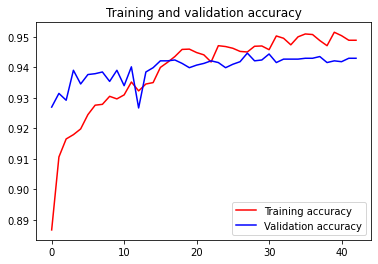

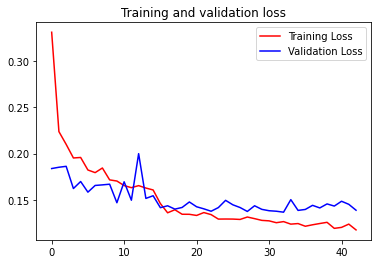

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()